## Imports and Dataset Setup

In [12]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras import layers
from datasets import load_dataset
from tiny_imagenet import TinyImagenetDataset
assert float(tf.__version__[:3]) >= 2.3

# Set random seeds for reproducibility
SEED = 3
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set the desired activation function
AF = 'relu'

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')


Running on Python Version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
Using Tensorflow Version: 2.6.2
Using GPU at: /device:GPU:0 (of 1 available)


In [13]:
# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/Mluckydwyer/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the clas
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

# define function to print top n accuracy
def print_top_n_accuracy(n, ds_val, model, batch_size=32):
    total = acc_top_n = 0

    for batch in ds_val.batch(batch_size):
        # Make a prediction
        pred = model.predict(batch["image"].numpy())
        top_n = tf.math.top_k(pred, k=n).indices
        
        # np.isin() returns a boolean array where the value is True if the element of the first input is in the second input
        # np.sum() sums the boolean array, which is the same as counting the number of True values
        acc_top_n += np.sum(np.isin(batch["label"].numpy(), top_n))
        
        total += len(batch["label"].numpy())

    print(f'Top-{n} Accuracy: {acc_top_n / total}, total images: {total}')


/home/sszabo/github/CPRE587/lab4/sw/.venv/lib64/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


--- Train & Validation dataset info ---
Train: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Validation: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>

--- Show an example image ---
Label: b'mantis, mantid' (class index: 51 - id: b'n02236044')

 Show some other examples


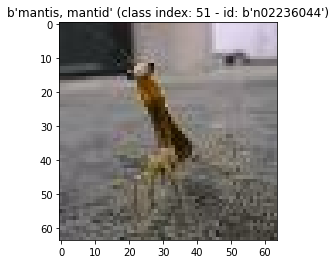

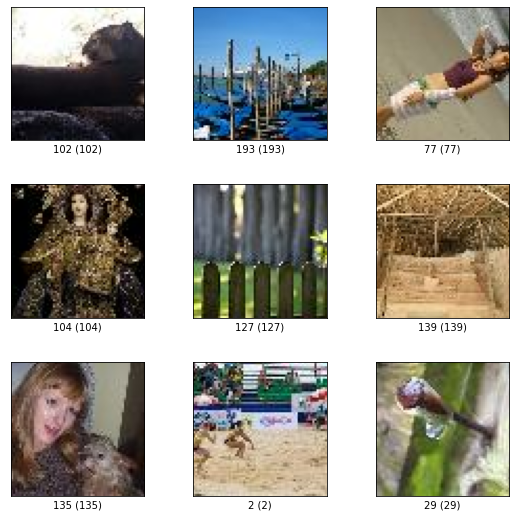

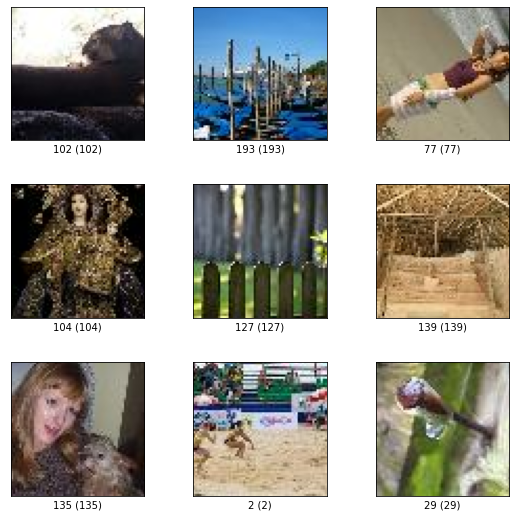

In [14]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


In [15]:
# Print all of the possible classes of the dataset and report how many there are in each split (train + validation)

# count all the unique classes in a dataset
def count_class(ds):
    class_count = {}
    num_unique = 0
    for img_data in ds:
        label = img_data["label"].numpy()
        if label in class_count:
            class_count[label] += 1
        else:
            class_count[label] = 1
            num_unique += 1
    return class_count, num_unique

# sum the class counts for each split
class_counts_train, count_unique_train = count_class(ds_train)
class_counts_val, count_unique_val = count_class(ds_val)

# Print all the classes present in the entire dataset
print(f'Entire dataset class IDs: {ds_info.features["label"].names}')
print(f'Number of classes in entire dataset: {len(ds_info.features["label"].names)}')

# Print the number of classes in each split
print(f'Number of unique Classes in Train: {count_unique_train}')
print(f'Number of unique Classes in Validation: {count_unique_val}')

# print the total number of images in the dataset
# print(f'Total number of images in dataset: {ds_info.splits["train"].num_examples + ds_info.splits["validation"].num_examples}')
print(f'Total number of images in dataset: {len(ds_train) + len(ds_val)}')


Entire dataset class IDs: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154'

In [16]:
"""
# If the dataset is gated/private, make sure you have run huggingface-cli login
# dataset = load_dataset("imagenet-1k", use_auth_token=True) # TODO ssz too much data


# manual download of data
# get imagenet labels
labels_path = tf.keras.utils.get_file("ImageNetLabels.txt","https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")
imagenet_labels = np.array(open(labels_path).read().splitlines())

# Set data_dir to a read-only storage of .tar files
# Set write_dir to a w/r storage
data_dir = "datasets/imagenet/r"
write_dir = "datasets/imagenet/rw"

# construct a tf.data.Dataset
download_config = tfds.download.DownloadConfig(
    extract_dir=os.path.join(data_dir, 'extracted'),
    manual_dir=os.path.join(data_dir)
)

dp_kwargs = {
    "download_dir": os.path.join(write_dir, 'downloaded'),
    "download_config": download_config
}

# TODO ssz can not download the entire dataset because it is WAYYY too large and 
# the files for the subset can not be found anywhere...
ds = tfds.load('imagenet2012_subset',
               data_dir=os.path.join(write_dir, 'data'),
               split='train',
               shuffle_files=False,
               download=True,
               as_supervised=True,
               download_and_prepare_kwargs=dp_kwargs
)

def resize_and_crop(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    imt = keras.applications.resnet.preprocess_input(img)
    return (img, label)

ds = ds.map(resize_and_crop)

# show a couple images
ds_sample = ds.take(3)
for sample in ds_sample:
    img, label = sample[0], sample[1]
    print(f"Image shape: {img.shape}, label: {label}")
    plt.imshow(tf.squeeze(img, axis=0))
    plt.show()

"""

'\n# If the dataset is gated/private, make sure you have run huggingface-cli login\n# dataset = load_dataset("imagenet-1k", use_auth_token=True) # TODO ssz too much data\n\n\n# manual download of data\n# get imagenet labels\nlabels_path = tf.keras.utils.get_file("ImageNetLabels.txt","https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")\nimagenet_labels = np.array(open(labels_path).read().splitlines())\n\n# Set data_dir to a read-only storage of .tar files\n# Set write_dir to a w/r storage\ndata_dir = "datasets/imagenet/r"\nwrite_dir = "datasets/imagenet/rw"\n\n# construct a tf.data.Dataset\ndownload_config = tfds.download.DownloadConfig(\n    extract_dir=os.path.join(data_dir, \'extracted\'),\n    manual_dir=os.path.join(data_dir)\n)\n\ndp_kwargs = {\n    "download_dir": os.path.join(write_dir, \'downloaded\'),\n    "download_config": download_config\n}\n\n# TODO ssz can not download the entire dataset because it is WAYYY too large and \n# the files for the 

## Build The Models

In [17]:

"""
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""

# https://keras.io/guides/serialization_and_saving/ 
# https://keras.io/guides/customizing_saving_and_serialization/ 
# https://keras.io/api/saving/model_config_serialization/ 
# https://keras.io/api/layers/base_layer/#get_config-method


# Standard ResNet Block class
class ResNetBlock(keras.Model):
    def __init__(self, channels, downsample=False, **kwargs):
        super().__init__()
        self.__channels = channels
        self.__downsample = downsample
        
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        # Use he_normal becuase activations are not linear for ReLU and PReLU and he_normal produces better results
        self.__INIT_SCHEME = 'he_normal'
        
        if len(kwargs) > 0:
            all_vars_set = reduce(operator.and_, [k in kwargs for k in ['conv1', 'conv2', 'shortcut']])
            if not all_vars_set:
                raise ValueError(f'Not all variables were set in {kwargs}')
            for k, v in kwargs.items():
                setattr(self, k, v)
        else:
            self.shortcut = keras.Sequential()
            if self.__downsample:
                # same kernel size, strides is 2
                self.conv1 = layers.Conv2D(self.__channels, kernel_size=3, strides=2, padding='same', kernel_initializer=self.__INIT_SCHEME)
                # the shortcut layer is a linear stack of layers (Sequential) 
                # it is a Conv2D with kernel size of 1 and strides of 2 to downsample the input
                self.shortcut.add(layers.Conv2D(self.__channels, kernel_size=1, strides=2, padding='same', kernel_initializer=self.__INIT_SCHEME))
                self.shortcut.add(layers.BatchNormalization())
            else:
                # same kernel size, strides is 1
                self.conv1 = layers.Conv2D(self.__channels, kernel_size=3, strides=1, padding='same', kernel_initializer=self.__INIT_SCHEME)
            self.conv2 = layers.Conv2D(self.__channels, kernel_size=3, strides=1, padding='same', kernel_initializer=self.__INIT_SCHEME)
    
    # TODO ssz do not return ReLu directly at the end of the call function
    # Due to: By returning a ReLu object tf.Variable(s) are created (weights, bias of conv layer) each time you call according to StackOverflow
    def call(self, input):
        shortcut = self.shortcut(input)
        
        io = self.conv1(input)
        io = layers.BatchNormalization()(io)
        io = layers.ReLU()(io)
        
        io = self.conv2(io)
        io = layers.BatchNormalization()(io)
        io = layers.ReLU()(io)
        
        io = layers.add([io, shortcut])
        io = layers.ReLU()(io)
        return io

    def get_config(self):
        # create custom python serializable dictionary containing the configuration of all layers
        # base_config = super().get_config()
        # config = {
        #     'channels': self.__channels,
        #     'downsample': self.__downsample,
        #     'conv1': self.conv1.get_config(),
        #     'conv2': self.conv2.get_config(),
        #     'shortcut': self.shortcut.get_config()
        # }
        config = {}
        config['channels'] = self.__channels
        config['downsample'] = self.__downsample
        config['conv1'] = keras.layers.serialize(self.conv1)
        config['conv2'] = keras.layers.serialize(self.conv2)
        config['shortcut'] = keras.layers.serialize(self.shortcut)
        # config['conv1'] = self.conv1.get_config()
        # config['conv2'] = self.conv2.get_config()
        # config['shortcut'] = self.shortcut.get_config()
        return config
    
    @classmethod
    def from_config(cls, config):
        # create a new instance of the class with the parameters stored in config
        key_args = {}
        key_args['conv1'] = keras.layers.deserialize(config['conv1'])
        key_args['conv2'] = keras.layers.deserialize(config['conv2'])
        key_args['shortcut'] = keras.layers.deserialize(config['shortcut'])
        # channels=config['channels'], downsample=config['downsample'],
        return cls(channels=config['channels'], downsample=config['downsample'], **key_args)
    
    def export_weights(self, path, idx):
        conv_idx = bias_idx = 0
        for layer in self.layers:
            if isinstance(layer, layers.Conv2D):
                weight_file_name = os.path.join(path, f'ResNetBlock{idx}', f'conv{conv_idx}_weights.bin')
                conv_idx += 1
            elif isinstance(layer, layers.Dense):
                bias_file_name = os.path.join(path, f'ResNetBlock{idx}', f'dense{bias_idx}_bias.bin')
                bias_idx += 1
            else:
                print(f'Layer {layer} is not supported')
                continue
            
            print(f'Exporting Layer {layer}')
            # flatten the weights to 1D array
            weights = layer.get_weights()[0].flatten()
            biases = layer.get_weights()[1].flatten()
            
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file_name = open(bias_file_name, 'wb')
            bias_file_name.write(biases)
            bias_file_name.close()


# ResNet Bottleneck Block class for ResNet50 and higher
class ResNetBottleneckBlock(keras.Model):
    def __init__(self, channels, downsample=False, **kwargs):
        super().__init__()
        self.__channels = channels
        self.__downsample = downsample
        self.__INIT_SCHEME = 'he_normal'
        self.all_vars_set = False
        
        if len(kwargs) > 0:
            self.all_vars_set = reduce(operator.and_, [k in kwargs for k in ['conv1', 'conv2', 'conv3', 'shortcut']])
            if not self.all_vars_set:
                raise ValueError(f'Not all variables were set in {kwargs}')
            for k, v in kwargs.items():
                setattr(self, k, v)
        else:
            self.conv1 = layers.Conv2D(self.__channels, kernel_size=1, strides=1, padding='same', kernel_initializer=self.__INIT_SCHEME)
            if self.__downsample:
                self.conv2 = layers.Conv2D(self.__channels, kernel_size=3, strides=2, padding='same', kernel_initializer=self.__INIT_SCHEME)
            else:
                self.conv2 = layers.Conv2D(self.__channels, kernel_size=3, strides=1, padding='same', kernel_initializer=self.__INIT_SCHEME)
            self.conv3 = layers.Conv2D(self.__channels * 4, kernel_size=1, strides=1, padding='same', kernel_initializer=self.__INIT_SCHEME)
    
    def build(self, input_shape):
        if not self.all_vars_set:
            self.shortcut = keras.Sequential()
            if self.__downsample or self.__channels * 4 != input_shape[-1]:
                stride = 2 if self.__downsample else 1
                self.shortcut.add(layers.Conv2D(self.__channels * 4, kernel_size=1, strides=stride, padding='same', kernel_initializer=self.__INIT_SCHEME))
                self.shortcut.add(layers.BatchNormalization())
            self.all_vars_set = True
    
    # TODO ssz do not return ReLu directly at the end of the call function
    # Due to: By returning a ReLu object tf.Variable(s) are created (weights, bias of conv layer) each time you call according to StackOverflow
    def call(self, input):
        shortcut = self.shortcut(input)
        
        io = self.conv1(input)
        io = layers.BatchNormalization()(io)
        io = layers.ReLU()(io)
        
        io = self.conv2(io)
        io = layers.BatchNormalization()(io)
        io = layers.ReLU()(io)
        
        io = self.conv3(io)
        io = layers.BatchNormalization()(io)
        io = layers.ReLU()(io)
        
        io = layers.add([io, shortcut])
        io = layers.ReLU()(io)
        return io
    
    def get_config(self):
        config = {}
        config['channels'] = self.__channels
        config['downsample'] = self.__downsample
        # config['conv1'] = keras.utils.serialize_keras_object(self.conv1)
        config['conv1'] = keras.layers.serialize(self.conv1)
        config['conv2'] = keras.layers.serialize(self.conv2)
        config['conv3'] = keras.layers.serialize(self.conv3)
        config['shortcut'] = keras.layers.serialize(self.shortcut)
        return config
    
    @classmethod
    def from_config(cls, config):
        # create a new instance of the class with the parameters stored in config
        key_args = {}
        key_args['conv1'] = keras.layers.deserialize(config['conv1'])
        key_args['conv2'] = keras.layers.deserialize(config['conv2'])
        key_args['conv3'] = keras.layers.deserialize(config['conv3'])
        key_args['shortcut'] = keras.layers.deserialize(config['shortcut'])
        # channels=config['channels'], downsample=config['downsample'],
        return cls(channels=config['channels'], downsample=config['downsample'], **key_args)
    
    def export_weights(self, path, idx):
        conv_idx = bias_idx = 0
        for layer in self.layers:
            if isinstance(layer, layers.Conv2D):
                weight_file_name = os.path.join(path, f'ResNetBottleneckBlock{idx}', f'conv{conv_idx}_weights.bin')
                conv_idx += 1
            elif isinstance(layer, layers.Dense):
                bias_file_name = os.path.join(path, f'ResNetBottleneckBlock{idx}', f'dense{bias_idx}_bias.bin')
                bias_idx += 1
            else:
                print(f'Layer {layer} is not supported')
                continue
            
            print(f'Exporting Layer {layer}')
            # flatten the weights to 1D array
            weights = layer.get_weights()[0].flatten()
            biases = layer.get_weights()[1].flatten()
            
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file_name = open(bias_file_name, 'wb')
            bias_file_name.write(biases)
            bias_file_name.close()


# ResNet model base class
class ResNet(keras.Model):
    def __init__(self, resnet_block, repetitions, num_classes=1000, **kwargs):
        super().__init__()
        self.__resnet_block = resnet_block
        self.__repetitions = repetitions
        self.__num_classes = num_classes
        self.__INIT_SCHEME = 'he_normal'
        
        if len(kwargs) > 0:
            all_vars_set = reduce(operator.and_, [k in kwargs for k in ['layer0', 'layer1', 'layer2', 'layer3', 'layer4', 'ap', 'flat', 'fc']])
            if not all_vars_set:
                raise ValueError(f'Not all variables were set in {kwargs}')
            for k, v in kwargs.items():
                setattr(self, k, v)
        else:
            self.layer0 = keras.Sequential([
                # TODO ssz originally kernel_size=7, strides=2
                layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.__INIT_SCHEME),
                layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU()
            ], name='layer0')
            
            self.layer1 = keras.Sequential([
                self.__resnet_block(64) for _ in range(self.__repetitions[0])
            ], name='layer1')
            
            self.layer2 = keras.Sequential([
                self.__resnet_block(128, downsample=True)
            ] + [
                self.__resnet_block(128) for _ in range(1, self.__repetitions[1])
            ], name='layer2')
            
            self.layer3 = keras.Sequential([
                self.__resnet_block(256, downsample=True)
            ] + [
                self.__resnet_block(256) for _ in range(1, self.__repetitions[2])
            ], name='layer3')
            
            self.layer4 = keras.Sequential([
                self.__resnet_block(512, downsample=True)
            ] + [
                self.__resnet_block(512) for _ in range(1, self.__repetitions[3])
            ], name='layer4')
            
            # TODO ssz originally GolbalAveragePooling2D
            self.ap = layers.GlobalAveragePooling2D()
            self.flat = layers.Flatten()
            self.fc = layers.Dense(self.__num_classes, activation='softmax')
    
    def call(self, input):
        io = self.layer0(input)
        io = self.layer1(io)
        io = self.layer2(io)
        io = self.layer3(io)
        io = self.layer4(io)
        io = self.ap(io)
        io = self.flat(io)
        io = self.fc(io)
        return io
    
    def get_config(self):
        config = {}
        config['layer0'] = keras.layers.serialize(self.layer0)
        config['layer1'] = keras.layers.serialize(self.layer1)
        config['layer2'] = keras.layers.serialize(self.layer2)
        config['layer3'] = keras.layers.serialize(self.layer3)
        config['layer4'] = keras.layers.serialize(self.layer4)
        config['ap'] = keras.layers.serialize(self.ap)
        config['flat'] = keras.layers.serialize(self.flat)
        config['fc'] = keras.layers.serialize(self.fc)
        config['resnet_block'] = keras.layers.serialize(self.__resnet_block)
        config['repetitions'] = self.__repetitions
        config['num_classes'] = self.__num_classes
        return config
    
    @classmethod
    def from_config(cls, config):
        # create a new instance of the class with the parameters stored in config
        key_args = {}
        key_args['layer0'] = keras.layers.deserialize(config['layer0'])
        key_args['layer1'] = keras.layers.deserialize(config['layer1'])
        key_args['layer2'] = keras.layers.deserialize(config['layer2'])
        key_args['layer3'] = keras.layers.deserialize(config['layer3'])
        key_args['layer4'] = keras.layers.deserialize(config['layer4'])
        key_args['ap'] = keras.layers.deserialize(config['ap'])
        key_args['flat'] = keras.layers.deserialize(config['flat'])
        key_args['fc'] = keras.layers.deserialize(config['fc'])
        
        config['resnet_block'] = keras.layers.deserialize(config['resnet_block'])
        return cls(resnet_block=config['resnet_block'], repetitions=config['repetitions'], num_classes=config['num_classes'], **key_args)
    
    def export_weights(self, path):
        if not os.path.exists(path):
            os.mkdir(path)
        for idx, layer in enumerate(self.layers):
            if isinstance(layer, self.__resnet_block):
                layer.export_weights(path, idx)
            else:
                print(f'Layer {layer} is not supported')
                continue


class ResNet18(ResNet):
    def __init__(self, num_classes=1000):
        super().__init__(ResNetBlock, [2, 2, 2, 2], num_classes=num_classes)
    
    def call(self, input):
        return super().call(input)
    
    def model(self, input_shape=(224, 224, 3)):
        io = keras.Input(shape=input_shape)
        model = keras.Model(inputs=io, outputs=self.call(io))
        return model
    
    def export_weights(self, path):
        super().export_weights(path)


class ResNet50(ResNet):
    def __init__(self, num_classes=1000):
        super().__init__(ResNetBottleneckBlock, [3, 4, 6, 3], num_classes=num_classes)
    
    def call(self, input):
        return super().call(input)
    
    def model(self, input_shape=(224, 224, 3)):
        io = keras.Input(shape=input_shape)
        model = keras.Model(inputs=io, outputs=self.call(io))
        return model


# ResNet18 model class original
class ResNet18_orig(keras.Model):
    # num_classes is the number of classes in specific classification task
    def __init__(self, num_classes=1000):
        super().__init__()
        self.__INIT_SCHEME = 'he_normal'
        
        self.layer0 = keras.Sequential([
            # TODO ssz originally kernel_size=7, strides=2
            layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.__INIT_SCHEME),
            layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            # layers.BatchNormalization(),
            layers.ReLU()
        ], name='layer0')
        
        self.layer1 = keras.Sequential([
            ResNetBlock(64),
            ResNetBlock(64)
        ], name='layer1')
        
        self.layer2 = keras.Sequential([
            ResNetBlock(128, downsample=True),
            ResNetBlock(128)
        ], name='layer2')
        
        self.layer3 = keras.Sequential([
            ResNetBlock(256, downsample=True),
            ResNetBlock(256)
        ], name='layer3')
        
        self.layer4 = keras.Sequential([
            ResNetBlock(512, downsample=True),
            ResNetBlock(512)
        ], name='layer4')
        
        self.ap = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')
    
    def call(self, input):
        io = self.layer0(input)
        io = self.layer1(io)
        io = self.layer2(io)
        io = self.layer3(io)
        io = self.layer4(io)
        io = self.ap(io)
        io = self.fc(io)
        return io
    
    def model(self, input_shape=(224, 224, 3)):
        io = keras.Input(shape=input_shape)
        model = keras.Model(inputs=io, outputs=self.call(io))
        return model


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
layer0 (Sequential)          (None, 64, 64, 64)        2048      
_________________________________________________________________
layer1 (Sequential)          (None, 64, 64, 64)        147712    
_________________________________________________________________
layer2 (Sequential)          (None, 32, 32, 128)       525440    
_________________________________________________________________
layer3 (Sequential)          (None, 16, 16, 256)       2099456   
_________________________________________________________________
layer4 (Sequential)          (None, 8, 8, 512)         8393216   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0   

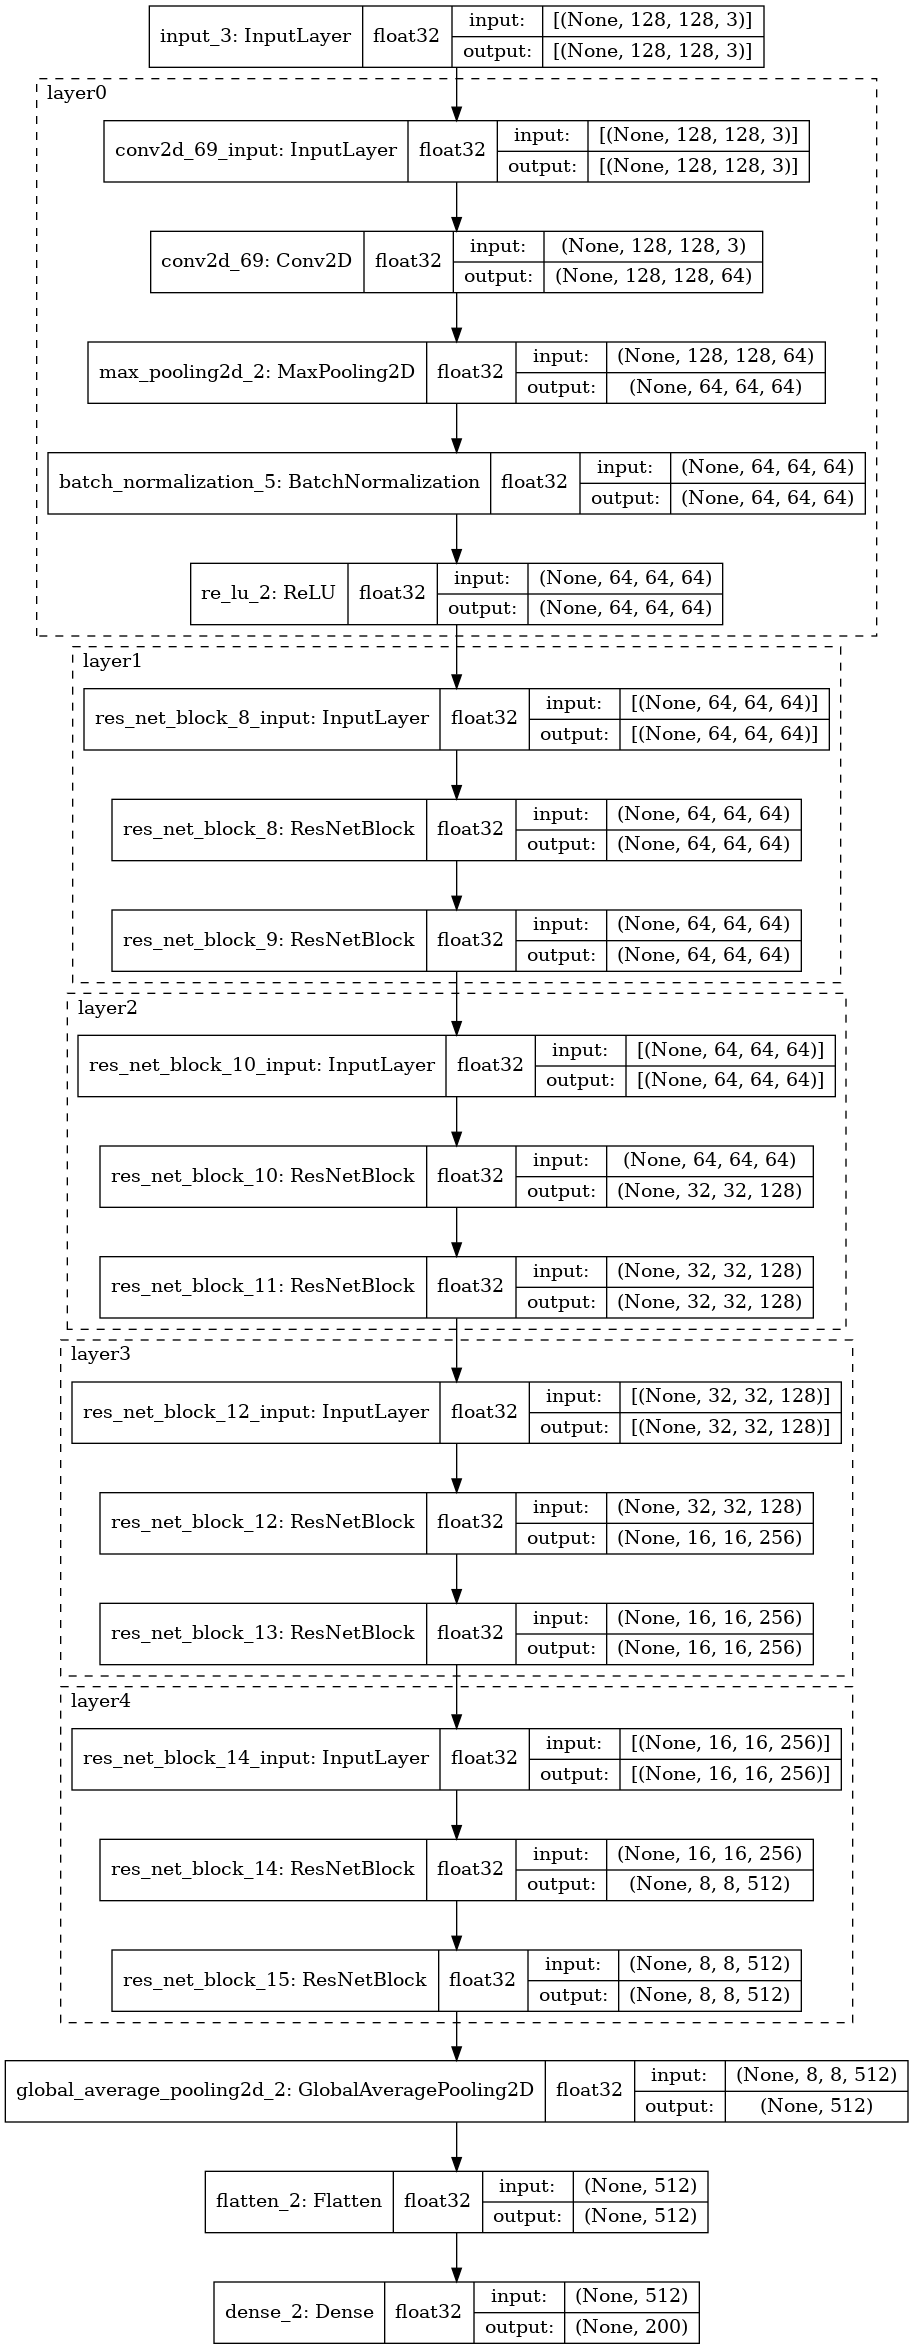

In [18]:
# create ResNet18 model
resnet18_model = ResNet18(num_classes=200)
resnet18_model = resnet18_model.model(input_shape=(128, 128, 3))
resnet18_model.summary()
tf.keras.utils.plot_model(resnet18_model, "resnet18_model.png", show_shapes=True, show_dtype=True, expand_nested=True) # Uncomment this to generate an image visualization


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
layer0 (Sequential)          (None, 64, 64, 64)        2048      
_________________________________________________________________
layer1 (Sequential)          (None, 64, 64, 256)       215424    
_________________________________________________________________
layer2 (Sequential)          (None, 32, 32, 512)       1218048   
_________________________________________________________________
layer3 (Sequential)          (None, 16, 16, 1024)      7092224   
_________________________________________________________________
layer4 (Sequential)          (None, 8, 8, 2048)        14961664  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0   

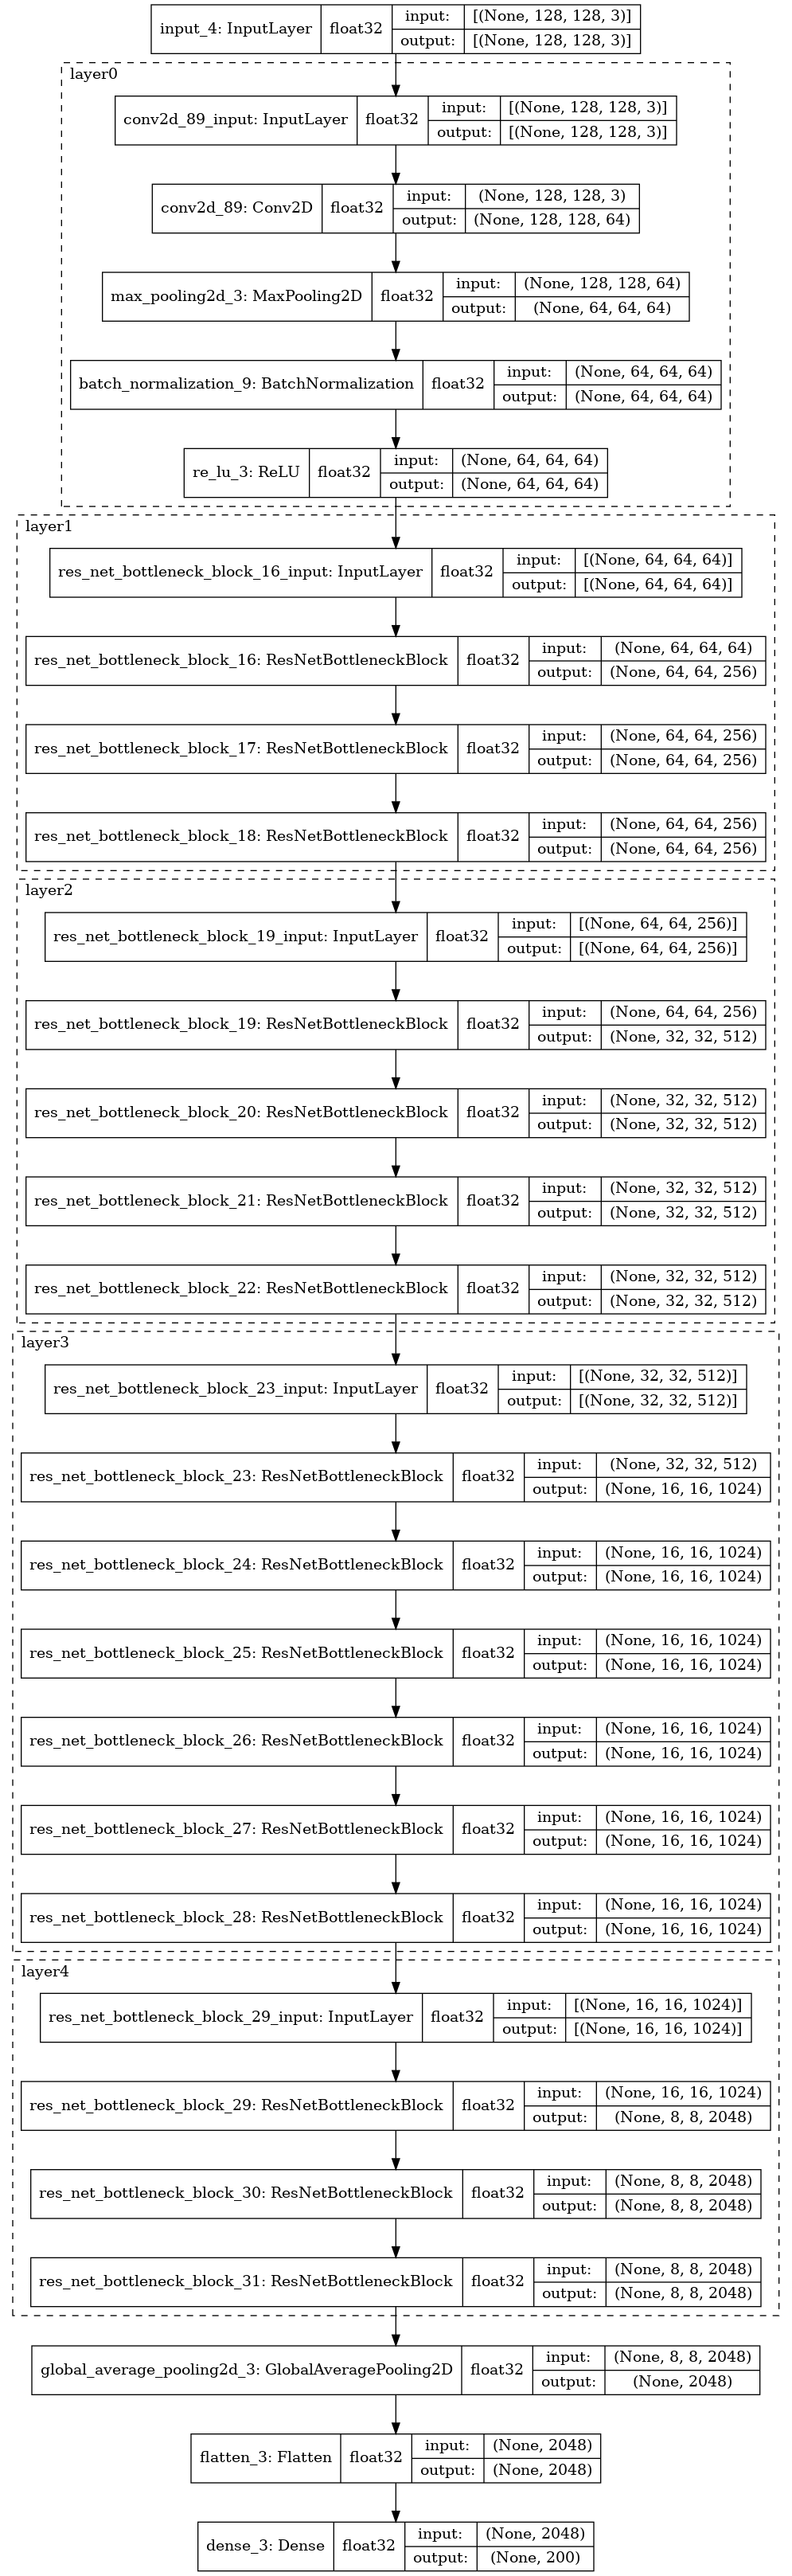

In [19]:
# create ResNet50 model
resnet50_model = ResNet50(num_classes=200)
resnet50_model = resnet50_model.model(input_shape=(128, 128, 3))
resnet50_model.summary()
tf.keras.utils.plot_model(resnet50_model, "resnet50_model.png", show_shapes=True, show_dtype=True, expand_nested=True) # Uncomment this to generate an image visualization

# pre-trained ResNet50 model (better)
# resnet50_model_pt = tf.keras.applications.ResNet50V2()
# resnet50_model_pt.summary()


## Train The Models

In [20]:
# train the models
from keras.callbacks import ModelCheckpoint, EarlyStopping

cur_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# ResNet18 train and log directories
train_dir18 = os.path.abspath(os.path.join('train_data18', cur_time))
pathlib.Path(train_dir18).mkdir(exist_ok=True, parents=True)

log_dir18 = os.path.abspath(os.path.join('log_data18', cur_time))
pathlib.Path(log_dir18).mkdir(exist_ok=True, parents=True)

# ResNet50 train and log directories
train_dir50 = os.path.abspath(os.path.join('train_data50', cur_time))
pathlib.Path(train_dir50).mkdir(exist_ok=True, parents=True)

log_dir50 = os.path.abspath(os.path.join('log_data50', cur_time))
pathlib.Path(log_dir50).mkdir(exist_ok=True, parents=True)

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0001)
resnet18_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Using early stopping to monitor validation accuracy
callbacks18 = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        restore_best_weights=False,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir=train_dir18, histogram_freq=1),
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(train_dir18, 'model18.h5'), save_best_only=True),
    keras.callbacks.CSVLogger(os.path.join(train_dir18, 'training18.csv'))
]

callbacks50 = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        restore_best_weights=False,
        verbose=1,
    ),
    keras.callbacks.TensorBoard(log_dir=train_dir50, histogram_freq=1),
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(train_dir50, 'model50.h5'), save_best_only=True),
    keras.callbacks.CSVLogger(os.path.join(train_dir50, 'training50.csv'))
]


In [21]:
from collections import deque


# !!! Depreciated
class ModelWeightExporter():
    # static variables
    layer_index = 0
    conv_idx = 0
    dense_idx = 0
    
    def __init__(self, model=None, model_name=None, model_dir=None):
        self.model = model
        self.model_name = model_name
        self.model_dir = model_dir
    
    def recursive_export_weights_helper(self, layer, in_seq=False, in_res=False):
        in_loop = in_seq or in_res
        
        if isinstance(layer, keras.layers.Conv2D):
            # convolutional layer
            weight_file_name = os.path.join(self.model_dir, f'l{self.layer_index}_conv{self.conv_idx}_weights.bin')
            bias_file_name = os.path.join(self.model_dir, f'l{self.layer_index}_conv{self.conv_idx}_bias.bin')
            
            print(f'Exporting layer {layer}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, in_res={in_res}')
            # flatten the weights to 1D array
            weights = layer.get_weights()[0].flatten()
            biases = layer.get_weights()[1].flatten()
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file = open(bias_file_name, 'wb')
            bias_file.write(biases)
            bias_file.close()
        elif isinstance(layer, keras.layers.Dense):
            # dense layer
            weight_file_name = os.path.join(self.model_dir, f'l{self.layer_index}_dense{self.dense_idx}_weights.bin')
            bias_file_name = os.path.join(self.model_dir, f'l{self.layer_index}_dense{self.dense_idx}_bias.bin')
            
            print(f'Exporting layer {layer}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, in_res={in_res}')
            # flatten the weights to 1D array
            weights = layer.get_weights()[0].flatten()
            biases = layer.get_weights()[1].flatten()
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file = open(bias_file_name, 'wb')
            bias_file.write(biases)
            bias_file.close()
        elif isinstance(layer, keras.Sequential):
            # sequential layer with multiple layers
            if len(layer.layers) == 0:
                print(f'Layer {layer} is empty, returning')
                return
            
            for i in range(len(layer.layers)):
                l = layer.layers[i]
                
                if isinstance(l, keras.layers.Conv2D):
                    self.conv_idx += 1
                elif isinstance(l, keras.layers.Dense):
                    self.dense_idx += 1
                
                if i == len(layer.layers) - 1:
                    print(f'Recursing into Layer {layer} => {l}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, False, in_res={in_res}')
                    self.recursive_export_weights_helper(l, False, in_res)
                else:
                    print(f'Recursing into Layer {layer} => {l}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, True, in_res={in_res}')
                    self.recursive_export_weights_helper(l, True, in_res)
        elif isinstance(layer, ResNetBlock) or isinstance(layer, ResNetBottleneckBlock):
            if len(layer.layers) == 0:
                print(f'Layer {layer} is empty, returning')
                return
            for i in range(len(layer.layers)):
                l = layer.layers[i]
                
                if isinstance(l, keras.layers.Conv2D):
                    self.conv_idx += 1
                elif isinstance(l, keras.layers.Dense):
                    self.dense_idx += 1
                
                if i == len(layer.layers) - 1:
                    print(f'Recursing into Model Layer {layer} => {l}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, in_res={in_res}, False')
                    self.recursive_export_weights_helper(l, in_seq, False)
                else:
                    print(f'Recursing into Model Layer {layer} => {l}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, in_res={in_res}, True')
                    self.recursive_export_weights_helper(l, in_seq, True)
        else:
            print(f'Layer {layer} export is not supported')
            if (self.layer_index < len(self.model.layers) - 1) and not in_loop:
                self.layer_index += 1
                l = self.model.layers[self.layer_index]
                
                if isinstance(l, keras.layers.Conv2D):
                    self.conv_idx += 1
                elif isinstance(l, keras.layers.Dense):
                    self.dense_idx += 1
                
                print(f'Recursing into Layer {l}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, False, in_res={in_res}, False')
                self.recursive_export_weights_helper(l, False, False)
            else:
                print(f'Layer {layer}, idx={self.layer_index} is the last layer, returning')
                return
        
        print(f'Checking if we can go to next layer, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, in_res={in_res}')
        if (self.layer_index < len(self.model.layers) - 1) and not in_loop:
            self.layer_index += 1
            l = self.model.layers[self.layer_index]
            
            if isinstance(l, keras.layers.Conv2D):
                self.conv_idx += 1
            elif isinstance(l, keras.layers.Dense):
                self.dense_idx += 1
            
            print(f'Recursing into Layer {l}, idx={self.layer_index}, conv_idx={self.conv_idx}, dense_idx={self.dense_idx}, in_seq={in_seq}, False, in_res={in_res}, False')
            self.recursive_export_weights_helper(l, False, False)
    
    def export_model_weights(self, model, model_name):
        self.model = model
        self.model_name = model_name
        
        # Make a directory for the data
        self.model_dir = os.path.abspath(os.path.join('model_weights', self.model_name))
        pathlib.Path(self.model_dir).mkdir(exist_ok=True)
        
        self.recursive_export_weights_helper(self.model.layers[0])
        self.reset_static_vars()
        
        print(f'Exported model weights to {self.model_dir}')
    
    def reset_static_vars(self):
        self.layer_index = 0
        self.conv_idx = 0
        self.dense_idx = 0


# !!! Depreciated
def export_model_weights_q(model, model_name):
    # Make a directory for the data
    model_dir = os.path.abspath(os.path.join('model_weights', model_name))
    pathlib.Path(model_dir).mkdir(exist_ok=True)
    
    layer_idx = conv_idx = dense_idx = 0
    layer_q = deque()
    layer_q.append(model.layers[layer_idx])
    popped_layer_idx = layer_idx
    in_seq = False
    in_res = False
    
    while len(layer_q) > 0:
        cur_layer = layer_q.popleft()
        
        if isinstance(cur_layer, keras.layers.Conv2D):
            # convolutional layer
            weight_file_name = os.path.join(model_dir, f'l{layer_idx}_conv{conv_idx}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'l{layer_idx}_conv{conv_idx}_bias.bin')
            
            print(f'Exporting layer {cur_layer}, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
            # flatten the weights to 1D array
            weights = cur_layer.get_weights()[0].flatten()
            biases = cur_layer.get_weights()[1].flatten()
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file = open(bias_file_name, 'wb')
            bias_file.write(biases)
            bias_file.close()
            
            conv_idx += 1
        elif isinstance(cur_layer, keras.layers.Dense):
            # dense layer
            weight_file_name = os.path.join(model_dir, f'l{layer_idx}_dense{dense_idx}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'l{layer_idx}_dense{dense_idx}_bias.bin')
            
            print(f'Exporting layer {cur_layer}, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
            # flatten the weights to 1D array
            weights = cur_layer.get_weights()[0].flatten()
            biases = cur_layer.get_weights()[1].flatten()
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file = open(bias_file_name, 'wb')
            bias_file.write(biases)
            bias_file.close()
            
            dense_idx += 1
        elif isinstance(cur_layer, keras.Sequential):
            # sequential layer with multiple layers
            if len(cur_layer.layers) == 0:
                print(f'Layer {cur_layer} is empty')
            else:
                for l in cur_layer.layers:
                    layer_q.append(l)
                print(f'\nAppended {len(cur_layer.layers)} layers, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
        elif isinstance(cur_layer, ResNetBlock) or isinstance(cur_layer, ResNetBottleneckBlock):
            # ResNet block layer
            if len(cur_layer.layers) == 0:
                print(f'Layer {cur_layer} is empty')
            else:
                for l in cur_layer.layers:
                    layer_q.append(l)
                print(f'\nAppended {len(cur_layer.layers)} layers, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
        else:
            print(f'Layer {cur_layer} export is not supported')
        
        # check if we can go to next layer
        if (len(layer_q) == 0) and (layer_idx < len(model.layers) - 1):
            layer_idx += 1
            layer_q.append(model.layers[layer_idx])
            print(f'\nGoing into Layer {model.layers[layer_idx]}, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
    
    print(f'Exported model weights to {model_dir}')


# *function to save and export all model weights
def export_model_weights(model, model_name):
    # Make a directory for the data
    model_dir = os.path.abspath(os.path.join('model_weights', model_name))
    pathlib.Path(model_dir).mkdir(exist_ok=True)
    
    layer_idx = conv_idx = dense_idx = 0
    layer_stack = []
    layer_stack.append(model.layers[layer_idx])
    
    while len(layer_stack) > 0:
        cur_layer = layer_stack.pop()
        
        if isinstance(cur_layer, keras.layers.Conv2D):
            # convolutional layer
            weight_file_name = os.path.join(model_dir, f'l{layer_idx}_conv{conv_idx}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'l{layer_idx}_conv{conv_idx}_bias.bin')
            
            print(f'Exporting layer {cur_layer}, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
            # flatten the weights to 1D array
            weights = cur_layer.get_weights()[0].flatten()
            biases = cur_layer.get_weights()[1].flatten()
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file = open(bias_file_name, 'wb')
            bias_file.write(biases)
            bias_file.close()
            
            conv_idx += 1
        elif isinstance(cur_layer, keras.layers.Dense):
            # dense layer
            weight_file_name = os.path.join(model_dir, f'l{layer_idx}_dense{dense_idx}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'l{layer_idx}_dense{dense_idx}_bias.bin')
            
            print(f'Exporting layer {cur_layer}, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
            # flatten the weights to 1D array
            weights = cur_layer.get_weights()[0].flatten()
            biases = cur_layer.get_weights()[1].flatten()
            # save the weights to binary files
            weight_file = open(weight_file_name, 'wb')
            weight_file.write(weights)
            weight_file.close()
            
            bias_file = open(bias_file_name, 'wb')
            bias_file.write(biases)
            bias_file.close()
            
            dense_idx += 1
        elif isinstance(cur_layer, keras.Sequential):
            # sequential layer with multiple layers
            if len(cur_layer.layers) == 0:
                print(f'Layer {cur_layer} is empty')
            else:
                for i in range(len(cur_layer.layers) - 1, -1, -1):
                    l = cur_layer.layers[i]
                    layer_stack.append(l)
                print(f'\nAppended {len(cur_layer.layers)} layers, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
        elif isinstance(cur_layer, ResNetBlock) or isinstance(cur_layer, ResNetBottleneckBlock):
            # ResNet block layer
            if len(cur_layer.layers) == 0:
                print(f'Layer {cur_layer} is empty')
            else:
                for i in range(len(cur_layer.layers) - 1, -1, -1):
                    l = cur_layer.layers[i]
                    layer_stack.append(l)
                print(f'\nAppended {len(cur_layer.layers)} layers, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
        else:
            print(f'Layer {cur_layer} export is not supported')
        
        # check if we can go to next layer
        if (len(layer_stack) == 0) and (layer_idx < len(model.layers) - 1):
            layer_idx += 1
            conv_idx = 0
            dense_idx = 0
            layer_stack.append(model.layers[layer_idx])
            print(f'\nGoing into Layer {model.layers[layer_idx]}, idx={layer_idx}, conv_idx={conv_idx}, dense_idx={dense_idx}')
    
    print(f'Exported model weights to {model_dir}')


# export_model_weights(resnet18_model, 'resnet18')
# print('\n')
# export_model_weights(resnet50_model, 'resnet50')


In [22]:
def normalize_img(img, label):
    # normalize pixel values to [0, 1] and resize to (128, 128) (from (64, 64))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, (128, 128))
    return (img, label)

def to_categorical(img, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200)
    return tf.cast(img, tf.float32), tf.cast(label, tf.int32)

BATCH_SIZE = 64
EPOCHS = 15

ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]
assert(isinstance(ds_retrain, tf.data.Dataset))
assert(isinstance(ds_reval, tf.data.Dataset))

ds_retrain = ds_retrain.cache().shuffle(1024)
ds_reval = ds_reval.cache().shuffle(1024)

ds_retrain_norm = ds_retrain.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval_norm = ds_reval.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain_norm = ds_retrain_norm.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval_norm = ds_reval_norm.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain_batch = ds_retrain_norm.batch(BATCH_SIZE)
ds_reval_batch = ds_reval_norm.batch(BATCH_SIZE)

resnet18_init_weights = resnet18_model.get_weights()

# handle: ValueError: tf.function-decorated function tried to create variables on non-first call.
# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio 
tf.config.run_functions_eagerly(True)

# https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers 
# resnet18_load = keras.models.load_model(os.path.join(log_dir, f'resnet18_batch_{BATCH_SIZE}.h5'), custom_objects={'ResNetBlock': ResNetBlock, 'ResNetBottleneckBlock': ResNetBottleneckBlock, 'ResNet': ResNet})
# resnet18_load.summary()

resnet18_history = resnet18_model.fit(ds_retrain_batch, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=ds_reval_batch, callbacks=callbacks18)


/home/sszabo/github/CPRE587/lab4/sw/.venv/lib64/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/15
1563/1563 [==============================] - 242s 153ms/step - loss: 4.4354 - accuracy: 0.0885 - val_loss: 18320319315968.0000 - val_accuracy: 0.0050
Epoch 2/15
1563/1563 [==============================] - 238s 152ms/step - loss: 3.4896 - accuracy: 0.2121 - val_loss: 922250005970944.0000 - val_accuracy: 0.0050
Epoch 3/15
1350/1563 [========================>.....] - ETA: 30s - loss: 3.0003 - accuracy: 0.2977

KeyboardInterrupt: 

In [ ]:
# save as JSON and as HDF5
saved_resnet18_arch = resnet18_model.to_json()
with open(os.path.join(log_dir18, f'resnet18_batch_{BATCH_SIZE}.json'), 'w') as json_file:
    json_file.write(saved_resnet18_arch)
resnet18_model.save(os.path.join(log_dir18, f'resnet18_batch_{BATCH_SIZE}.h5'), save_format='h5')

export_model_weights(resnet18_model, 'resnet18')

print_top_n_accuracy(1, ds_val, resnet18_model, BATCH_SIZE)
print_top_n_accuracy(5, ds_val, resnet18_model, BATCH_SIZE)

print("Done")


Layer <keras.engine.input_layer.InputLayer object at 0x7f5dac3a9ba8> export is not supported

Going into Layer <keras.engine.sequential.Sequential object at 0x7f5dac45acc0>, idx=1, conv_idx=0, dense_idx=0

Appended 4 layers, idx=1, conv_idx=0, dense_idx=0
Exporting layer <keras.layers.convolutional.Conv2D object at 0x7f5dac45a0b8>, idx=1, conv_idx=0, dense_idx=0
Layer <keras.layers.pooling.MaxPooling2D object at 0x7f5dac45a5c0> export is not supported
Layer <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5dac45a7f0> export is not supported
Layer <keras.layers.advanced_activations.ReLU object at 0x7f5dac45aba8> export is not supported

Going into Layer <keras.engine.sequential.Sequential object at 0x7f5dac336d30>, idx=2, conv_idx=0, dense_idx=0

Appended 2 layers, idx=2, conv_idx=0, dense_idx=0

Appended 3 layers, idx=2, conv_idx=0, dense_idx=0
Layer <keras.engine.sequential.Sequential object at 0x7f5dac4291d0> is empty
Exporting layer <keras.layers.conv

In [ ]:
# train ResNet50
resnet50_init_weights = resnet50_model.get_weights()

resnet50_history = resnet50_model.fit(ds_retrain_batch, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=ds_reval_batch, callbacks=callbacks50)


Epoch 1/15
1563/1563 [==============================] - 451s 288ms/step - loss: 5.0416 - accuracy: 0.0497 - val_loss: 431357551874941124608.0000 - val_accuracy: 0.0050
Epoch 2/15
1563/1563 [==============================] - 451s 288ms/step - loss: 4.2941 - accuracy: 0.1182 - val_loss: 676083943199994113104543744.0000 - val_accuracy: 0.0050
Epoch 3/15
1563/1563 [==============================] - 450s 288ms/step - loss: 3.8668 - accuracy: 0.1775 - val_loss: inf - val_accuracy: 0.0050
Epoch 4/15
1563/1563 [==============================] - 452s 289ms/step - loss: 3.5703 - accuracy: 0.2248 - val_loss: 33844931574971218238504534731128832.0000 - val_accuracy: 0.0048
Epoch 5/15
1563/1563 [==============================] - 450s 288ms/step - loss: 3.5363 - accuracy: 0.2341 - val_loss: nan - val_accuracy: 0.0046
Epoch 00005: early stopping


In [ ]:
# save as JSON and as HDF5
saved_resnet50_arch = resnet50_model.to_json()
with open(os.path.join(log_dir50, f'resnet50_batch_{BATCH_SIZE}.json'), 'w') as json_file:
    json_file.write(saved_resnet50_arch)
resnet50_model.save(os.path.join(log_dir50, f'resnet50_batch_{BATCH_SIZE}.h5'), save_format='h5')

export_model_weights(resnet50_model, 'resnet50')

print_top_n_accuracy(1, ds_val, resnet50_model, BATCH_SIZE)
print_top_n_accuracy(5, ds_val, resnet50_model, BATCH_SIZE)

print("Done")


Layer <keras.engine.input_layer.InputLayer object at 0x7f5dac436f98> export is not supported

Going into Layer <keras.engine.sequential.Sequential object at 0x7f5dac193748>, idx=1, conv_idx=0, dense_idx=0

Appended 4 layers, idx=1, conv_idx=0, dense_idx=0
Exporting layer <keras.layers.convolutional.Conv2D object at 0x7f5dac182860>, idx=1, conv_idx=0, dense_idx=0
Layer <keras.layers.pooling.MaxPooling2D object at 0x7f5dac193c50> export is not supported
Layer <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5dac193550> export is not supported
Layer <keras.layers.advanced_activations.ReLU object at 0x7f5dac193860> export is not supported

Going into Layer <keras.engine.sequential.Sequential object at 0x7f5dac1d2828>, idx=2, conv_idx=0, dense_idx=0

Appended 3 layers, idx=2, conv_idx=0, dense_idx=0

Appended 4 layers, idx=2, conv_idx=0, dense_idx=0
Exporting layer <keras.layers.convolutional.Conv2D object at 0x7f5dac171a20>, idx=2, conv_idx=0, dense_idx=0
Ex

ResNet18 History:
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


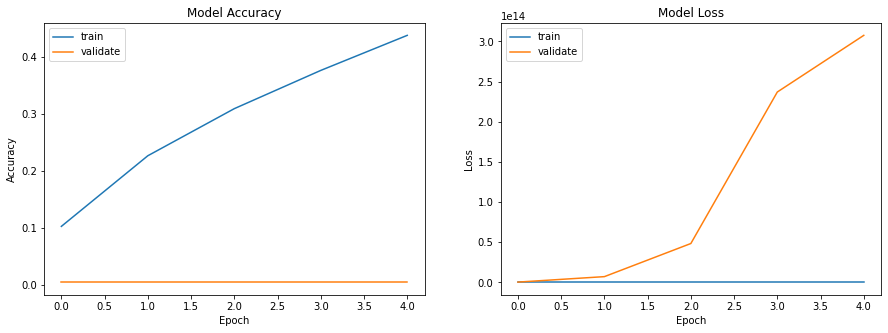

In [ ]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print("ResNet18 History:")
print(resnet18_history.history.keys())
plot_model_history(resnet18_history)


ResNet50 History:
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


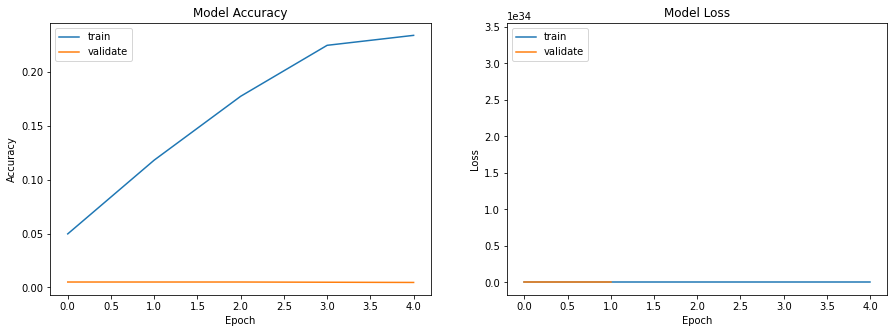

In [ ]:
print("ResNet50 History:")
print(resnet50_history.history.keys())
plot_model_history(resnet50_history)


## Evaluation

In [ ]:
# Evaluate the model
model_loss18, model_accuracy18 = resnet18_model.evaluate(ds_reval_batch)
model_loss50, model_accuracy50 = resnet50_model.evaluate(ds_reval_batch)

print('ResNet18 Model Loss is {}'.format(model_loss18))
print('ResNet18 Model Accuracy is {}'.format(model_accuracy18))
print()

print('ResNet50 Model Loss is {}'.format(model_loss50))
print('ResNet50 Model Accuracy is {}'.format(model_accuracy50))


157/157 [==============================] - 29s 183ms/step - loss: nan - accuracy: 0.0046
ResNet18 Model Loss is 307594115678208.0
ResNet18 Model Accuracy is 0.004999999888241291

ResNet50 Model Loss is nan
ResNet50 Model Accuracy is 0.004600000102072954
